In [3]:
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import os

In [14]:
def get_dataframe(filename: str, verbose: bool = False) -> pd.DataFrame:
    df = pd.read_pickle(filename, compression='gzip')
    if verbose:
        original_size = df.memory_usage(index=False, deep=True).sum() / 1_048_576
        print("old_size={:.1f} MB".format(original_size))
    
    df["p2a"] = df["p2a"].astype('datetime64')
    df.rename(columns = {"p2a": "date"}, inplace=True)
    
    keys = ['p36', 'weekday(p2a)', 'h', 'j', 'p', 'q', 't',
            'i', 'k', 'l', 'n', 'o', 'r', 's']
    
    df[keys] = df[keys].astype('category')
    
    if verbose:
        new_size = df.memory_usage(index=False, deep=True).sum() / 1_048_576
        print("new_size={:.1f} MB".format(new_size))
    return df

In [16]:
df = get_dataframe("accidents.pkl.gz", True)
df.info()

old_size=720.8 MB
new_size=301.9 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 487161 entries, 0 to 487160
Data columns (total 65 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   p1            487161 non-null  object        
 1   p36           487161 non-null  category      
 2   p37           487161 non-null  object        
 3   date          487161 non-null  datetime64[ns]
 4   weekday(p2a)  487161 non-null  object        
 5   p2b           487161 non-null  object        
 6   p6            487161 non-null  object        
 7   p7            487161 non-null  int32         
 8   p8            487161 non-null  int32         
 9   p9            487161 non-null  int32         
 10  p10           487161 non-null  int32         
 11  p11           487161 non-null  int32         
 12  p12           487161 non-null  int32         
 13  p13a          487161 non-null  int32         
 14  p13b          487161 non-null  i

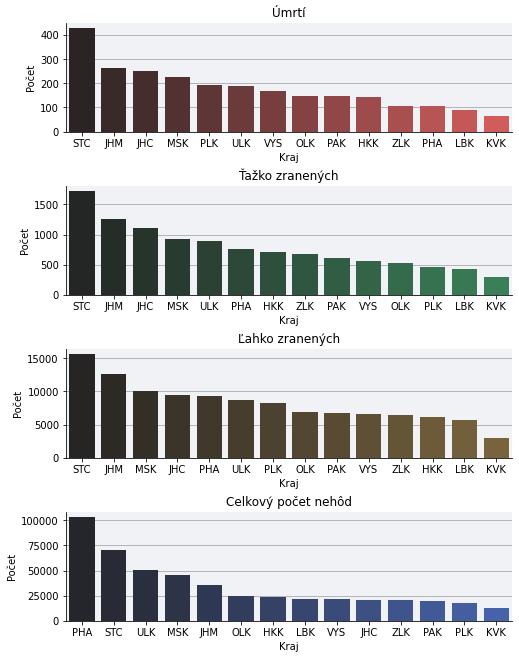

In [108]:
fig, axes = plt.subplots(4, 1, figsize=(8, 11))
ax = axes.flatten()

df_accidets = df.groupby(["region"]).agg({"p13a": "sum", "p13b": "sum", "p13c": "sum", "p1": "count"})
df_accidets.rename(columns= {"p1": "total_accidets"}, inplace=True)

tmp = df_accidets.reset_index()

palette = sns.dark_palette(color="#e34949", n_colors=tmp["region"].count())

plot = sns.catplot(data=df_regions, x="p53_class", col="region", hue="Príčina nehody", col_wrap=2, y="p53", kind="bar", height=4.2, aspect=1.1, zorder=2)

# sns.barplot(data=tmp, x="region", y="p13a",  ax=ax[0], palette=palette, zorder=2,
#             order=tmp.sort_values('p13a', ascending=False)["region"])

# palette = sns.dark_palette(color="seagreen", n_colors=tmp["region"].count())
# sns.barplot(data=tmp, x="region", y="p13b", ax=ax[1], palette=palette, zorder=2,
#             order=tmp.sort_values('p13b', ascending=False)["region"])

# palette = sns.dark_palette(color="#826633", n_colors=tmp["region"].count())
# sns.barplot(data=tmp, x="region", y="p13c",  ax=ax[2], palette=palette, zorder=2,
#             order=tmp.sort_values('p13c', ascending=False)["region"])

# palette = sns.dark_palette(color="#365bba", n_colors=tmp["region"].count())
# sns.barplot(data=tmp, x="region", y="total_accidets", ax=ax[3], palette=palette, zorder=2,
#             order=tmp.sort_values('total_accidets', ascending=False)["region"])
# sns.despine()

# ax[0].set(xlabel='Kraj', ylabel='Počet', title="Úmrtí", facecolor="#f0f2f5")
# ax[1].set(xlabel='Kraj', ylabel='Počet', title="Ťažko zranených", facecolor="#f0f2f5")
# ax[2].set(xlabel='Kraj', ylabel='Počet', title="Ľahko zranených", facecolor="#f0f2f5")
# ax[3].set(xlabel='Kraj', ylabel='Počet', title="Celkový počet nehôd", facecolor="#f0f2f5")
# ax[0].grid(axis="y", color="black", alpha=.5, linewidth=.5, zorder=1)
# ax[1].grid(axis="y", color="black", alpha=.5, linewidth=.5, zorder=1)
# ax[2].grid(axis="y", color="black", alpha=.5, linewidth=.5, zorder=1)
# ax[3].grid(axis="y", color="black", alpha=.5, linewidth=.5, zorder=1)
# plt.subplots_adjust(hspace = 0.5)


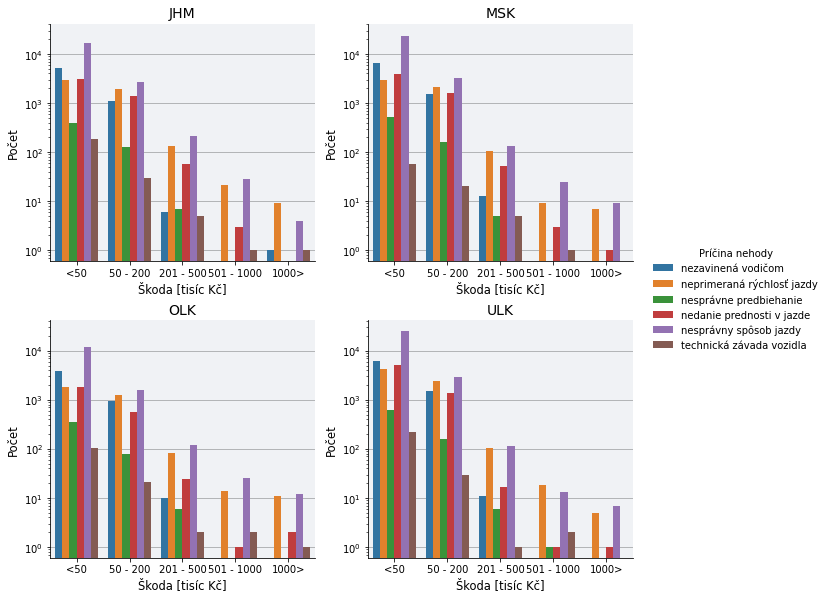

In [29]:

regions = ["OLK", "JHM", "ULK", "MSK"]

df_regions = df[["region", "p12", "p53"]].copy().set_index("region").loc[regions]
df_regions["p53"] = df_regions["p53"] / 10

bins = pd.IntervalIndex.from_tuples([(100, 100), (201, 209), (301, 311), (401, 414), (501, 516), (601, 615)], closed="both")
df_bins = pd.cut(df_regions["p12"].to_list(), bins=bins)
df_bins.categories = ["nezavinená vodičom",  "neprimeraná rýchlosť jazdy", "nesprávne predbiehanie", "nedanie prednosti v jazde", "nesprávny spôsob jazdy", "technická závada vozidla"]
df_regions["p12"] = df_bins

df_regions["p53_class"] = pd.cut(df_regions["p53"], [-1, 49, 200, 500, 1000, float("inf")], labels=["<50", "50 - 200", "201 - 500", "501 - 1000", "1000>"])

df_regions.rename(
    inplace=True,
    columns= {
        'p12': 'Príčina nehody'
    }
)

df_regions = df_regions.groupby(["region", "p53_class", "Príčina nehody"]).count().reset_index()

plot = sns.catplot(data=df_regions, x="p53_class", col="region", hue="Príčina nehody",                      col_wrap=2, y="p53", kind="bar", height=4.2, aspect=1.1, zorder=2)

plot.set_titles("{col_name}", size=14).tight_layout()

for ax in plot.axes.flatten():
    ax.tick_params(labelbottom=True, labelleft=True)
    ax.set_xlabel("Škoda [tisíc Kč]", fontsize=11.5)
    ax.set_ylabel("Počet", fontsize=11.5)
    ax.set_yscale("log")
    ax.grid(axis="y", color="black", alpha=.5, linewidth=.5, zorder=1)
    ax.set_facecolor("#f0f2f5")

plt.subplots_adjust(hspace=0.25, wspace=0.2)
plt.savefig("hell.jpg")


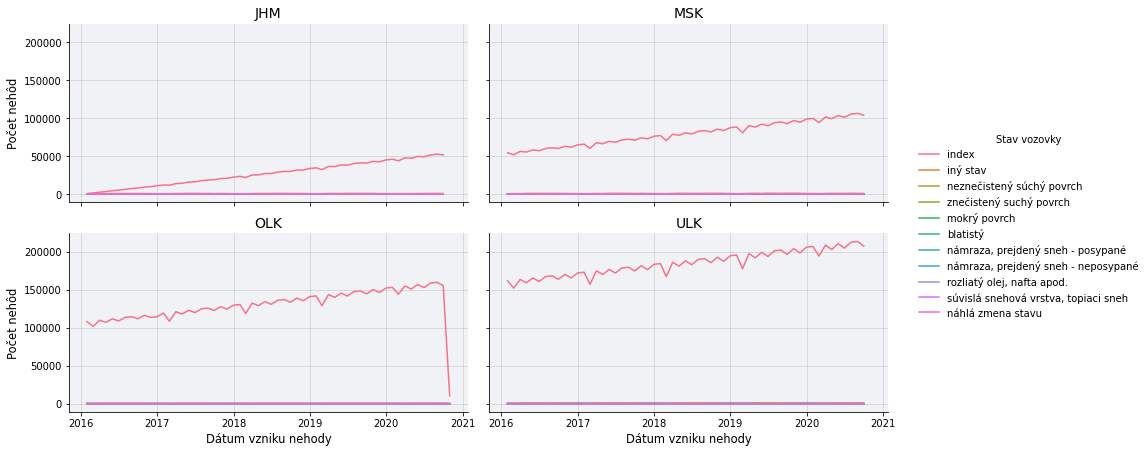

In [7]:
regions = ["OLK", "JHM", "ULK", "MSK"]
df_regions = df[["region", "date", "p16"]].copy().set_index("region").loc[regions].reset_index()
df_regions_crosstab = pd.crosstab([df_regions["region"], df_regions["date"]], df_regions["p16"], rownames=["region", "date"], colnames=["p16"])

df_regions_crosstab.reset_index()
df_regions_crosstab.rename(columns={
     0: 'iný stav',
     1: 'neznečistený súchý povrch',
     2: 'znečistený suchý povrch',
     3: 'mokrý povrch',
     4: 'blatistý',
     5: 'námraza, prejdený sneh - posypané',
     6: 'námraza, prejdený sneh - neposypané',
     7: 'rozliatý olej, nafta apod.',
     8: 'súvislá snehová vrstva, topiaci sneh',
     9: 'náhlá zmena stavu',
}, inplace=True)

df_regions_crosstab = df_regions_crosstab.reset_index().set_index("date")
df_regions_crosstab = df_regions_crosstab.groupby(["region"]).resample("M").sum().stack().reset_index().set_index("region")

df_regions_crosstab.rename(
     inplace=True,
     columns = {
          0: "počet nehod",
          "p16": "Stav vozovky"
     }
)


plot = sns.relplot(data=df_regions_crosstab, x="date", y="počet nehod", hue="Stav vozovky", kind="line", col="region", col_wrap=2,  ci=0, height=3.2, aspect=2, zorder=2)

(plot.set_xlabels("Dátum vzniku nehody", size=11.5)
     .set_ylabels("Počet nehôd", size=11.5)
     .set_titles("{col_name}", size=14)
     .tight_layout())

for ax in plot.axes.flatten():
    ax.grid(color="black", alpha=.2, linewidth=.5, zorder=1)
    ax.set_facecolor("#f0f2f5")


plt.savefig("hell2.jpg")
